# Some Plots

## Ditto

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
jtplot.style('grade3')

In [2]:
path_Ditto = './Eva/clear3-malicious1_Ditto_avg_acc_test_mnist.txt'
path_DittoHdbscan = './Eva/clear3-malicious1_DittoHdbscan_avg_acc_test_mnist.txt'
acc_Ditto = np.loadtxt(path_Ditto)
acc_DittoHdbscan = np.loadtxt(path_DittoHdbscan)

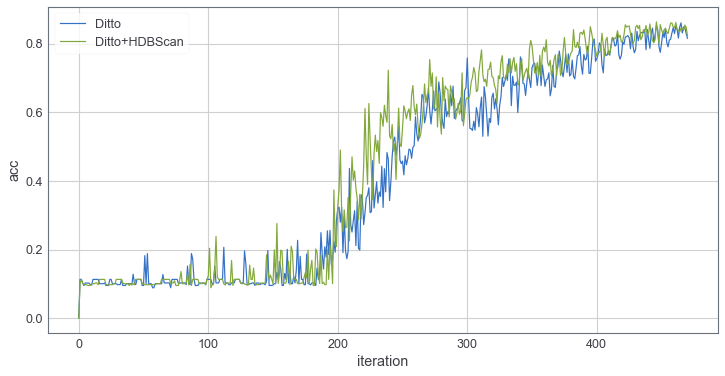

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(acc_Ditto)), acc_Ditto)
plt.plot(np.arange(len(acc_DittoHdbscan)), acc_DittoHdbscan)
plt.legend(['Ditto', 'Ditto+HDBScan'])
plt.xlabel('iteration')
plt.ylabel('acc')
plt.show()

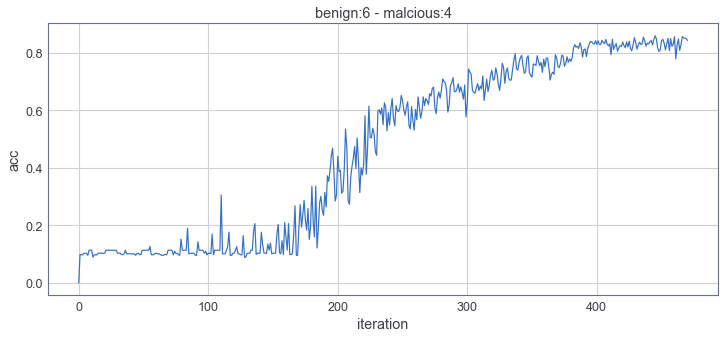

In [4]:
path_DittoHdbscan = './Eva/clear6-malicious4_DittoHdbscan_avg_acc_test_mnist.txt'
acc_DittoHdbscan = np.loadtxt(path_DittoHdbscan)
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(acc_DittoHdbscan)), acc_DittoHdbscan)
plt.title("benign:6 - malcious:4")
plt.xlabel('iteration')
plt.ylabel('acc')
plt.show()

## Adaptive Clipping

In [2]:
path = './Eva/clear10_serverAdaClipping_avg_acc_test.txt'
acc_server_clipping = np.loadtxt(path)

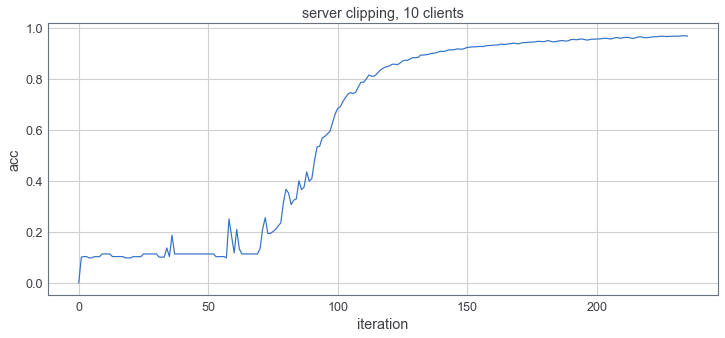

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(acc_server_clipping)), acc_server_clipping)
plt.title("server clipping, 10 clients")
plt.xlabel('iteration')
plt.ylabel('acc')
plt.show()

# HDBScan

In [14]:
import hdbscan
from sklearn.metrics.pairwise import pairwise_distances

In [25]:
cluster = hdbscan.HDBSCAN(metric='l2', min_cluster_size=2, allow_single_cluster=True, min_samples=1, cluster_selection_epsilon=0.1)
c1 = np.random.normal(0, 1, size=(20,2))
c2 = np.random.normal(5, 1, size=(20,2))
c3 = np.random.normal(-3, 1, size=(20,2))
data = [c1, c2, c3]
colors = ['r', 'b', 'y']

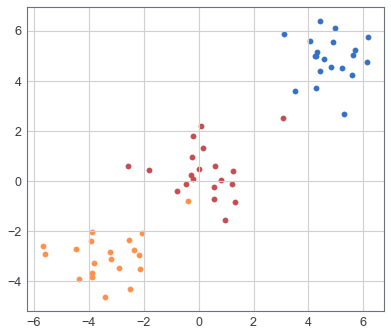

In [26]:
for i in range(len(data)):
    plt.scatter(data[i][:,0], data[i][:,1], c=colors[i])
plt.show()

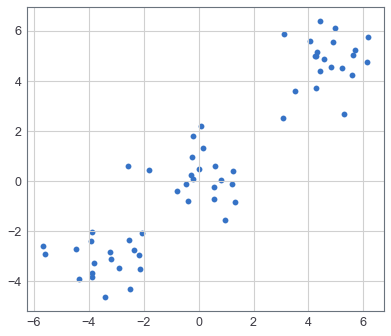

In [27]:
weights_in = np.array(data).reshape(60,2)
plt.scatter(weights_in[:,0], weights_in[:,1])
plt.show()

In [28]:
distance_matrix = pairwise_distances(weights_in, metric='cosine')
cluster.fit(distance_matrix) 
label = cluster.labels_

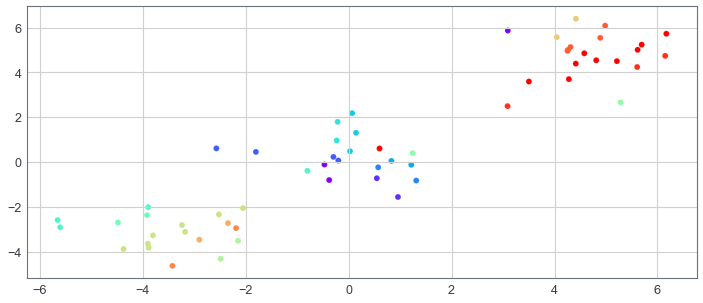

In [29]:
plt.figure(figsize=(12,5))
plt.scatter(weights_in[:,0], weights_in[:,1], c=label, cmap='rainbow')
plt.show()

In [34]:
num_workers = 60
b = []
if (label==-1).all():
    b = [i for i in range(num_workers)]
else:
    # bucket = np.zeros(label.shape)
    # for value in label:
    #     if value != -1:
    #         bucket[value] += 1
    # majority = np.argmax(bucket)
    # b = np.array(np.where(label == majority))
    # b = b.reshape(b.shape[1],).tolist()
    
    label_class, label_count = np.unique(label, return_counts=True)
    if -1 in label_class:
        label_class, label_count = label_class[1:], label_count[1:]
    majority = label_class[np.argmax(label_count)]
    b_ = np.where(label==majority)[0].tolist()


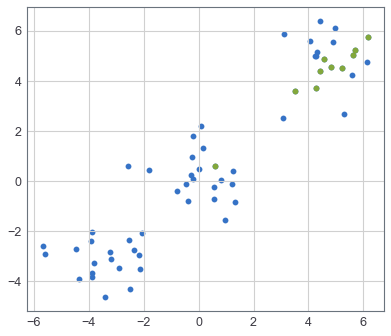

In [31]:
plt.scatter(weights_in[:,0], weights_in[:,1])
plt.scatter(weights_in[np.where(label==majority)][:,0], weights_in[np.where(label==majority)][:,1])
plt.show()

仅用HDBSCAN聚类的方法, 当malicious群体比较大的时候, 聚类容易丢弃 benign clients 而收集所有的 malicious clients, 这种情况下训练时, 可以发现 training accuracy 震荡十分严重, 所以说 FLGuard 里面提出来的用上一轮的 aggregated weights 还可以减轻这种极端情况带来的影响, 使得梯度下降更加平稳.

# Gradient Descent Adaptive Clipping

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
jtplot.style("grade3")

In [23]:
X = np.random.normal(20, 3, size=(100,1))

In [24]:
def clipping_func(x:np.ndarray, C:np.ndarray, gamma=0.5, lr=0.2, batch_size=10, epoch=5):
    C_record = []
    for e in range(epoch):
        for t in range(np.floor(len(x)/batch_size).astype(int)):
            x_slice = x[t*10:t*10+10]
            grad = np.sum(x_slice<=C)/len(x_slice) - gamma
            C *= np.exp(-lr*grad)
#             C -= -lr*grad
            C_record.append(C)
    return C, C_record

In [25]:
C, record_exp = clipping_func(X, 5)

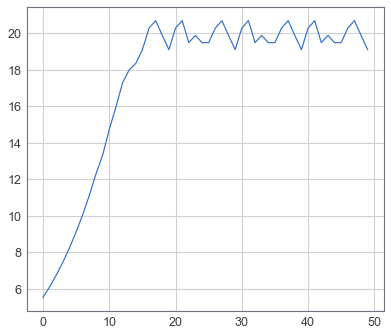

In [26]:
plt.plot(np.arange(len(record_exp)), record_exp)
plt.show()

# MeanShift Clustering

In [18]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from jupyterthemes import jtplot
jtplot.style("grade3")

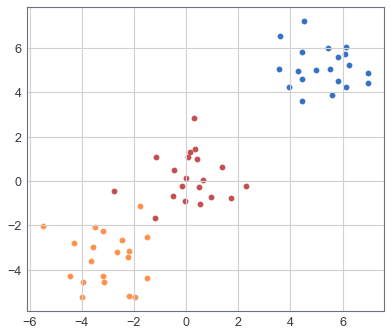

In [19]:
for i in range(len(data)):
    plt.scatter(data[i][:,0], data[i][:,1], c=colors[i])
plt.show()

In [20]:
weights_in = np.array(data).reshape(60,2)

In [21]:
bandwidth = estimate_bandwidth(weights_in, quantile=0.2)
mscluster = MeanShift(bandwidth=bandwidth, bin_seeding=False)
mscluster.fit(weights_in)
label = mscluster.labels_

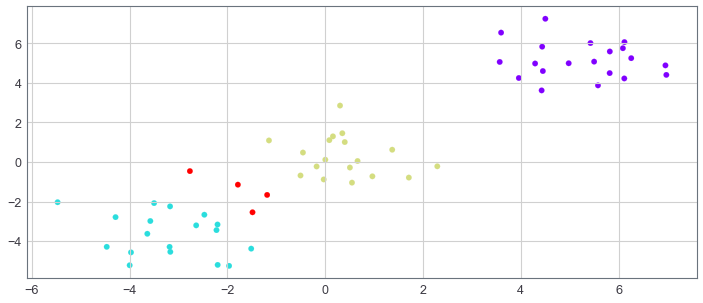

In [22]:
plt.figure(figsize=(12,5))
plt.scatter(weights_in[:,0], weights_in[:,1], c=label, cmap='rainbow')
plt.show()

# HDBScan+AaptiveClipping+Ditto

In [9]:
import pandas as pd 

def params_plot(load_path:str, save_path=None, title=None):
    data = pd.read_table(load_path, header=None)

    acc_record = []
    legends = []
    for i in range(1,len(data)+1,2):
        legends.append(data.iloc[i-1].item().strip())
        temp = data.iloc[i].item()
        acc_record.append(100*np.array(list(map(float,temp.strip().split(' ')))))

    plt.figure(figsize=(25,10))
    for i in range(len(legends)):
        plt.plot(np.arange(len(acc_record[i])), acc_record[i])
    plt.legend(legends)
    if title is not None:
        plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('acc[%]')
    if save_path is not None:
        plt.savefig(save_path, dpi=600)
    plt.show()

## Parameters Design

### Gamma (clipping ratio)

- b_noise = 0
- z_multiplier = 0

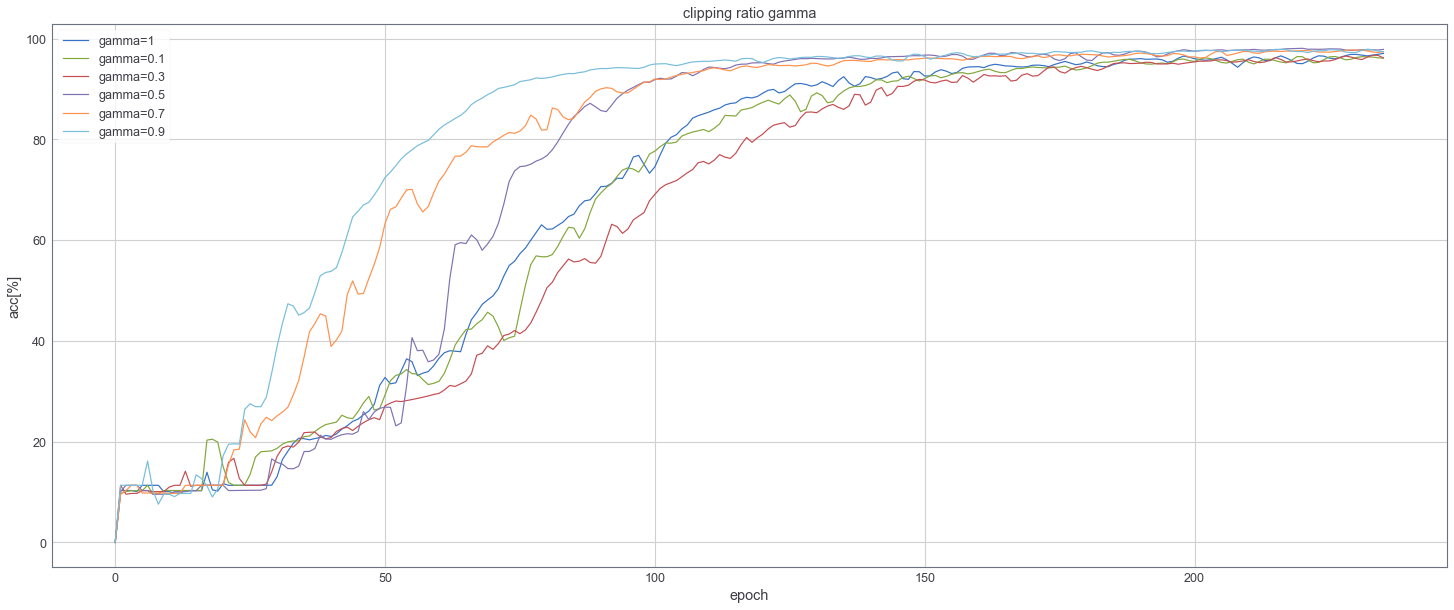

In [10]:
params_plot('./Eva/comb_params_setting/comb_clipping_gamma.txt', 
            './Eva/comb_params_setting/images/clipping_ratio.png',
            'clipping ratio gamma'
           )

### b_noise (noise std for indicators)

- gamma = 0.5
- z_multiplier = 0

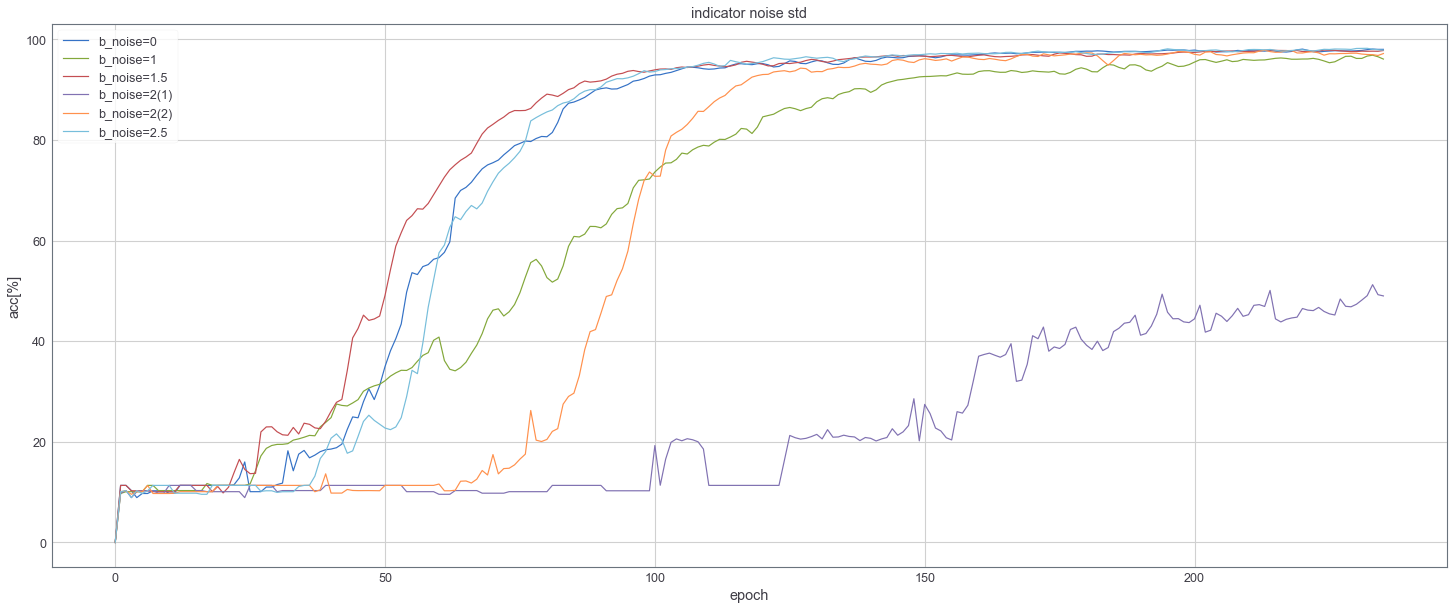

In [11]:
params_plot('./Eva/comb_params_setting/comb_clipping_bnoise.txt', 
            './Eva/comb_params_setting/images/clipping_bnoise.png',
            'indicator noise std'
           )

### z (noise multiplier)

- gamma = 0.5
- b_noise = 1.5

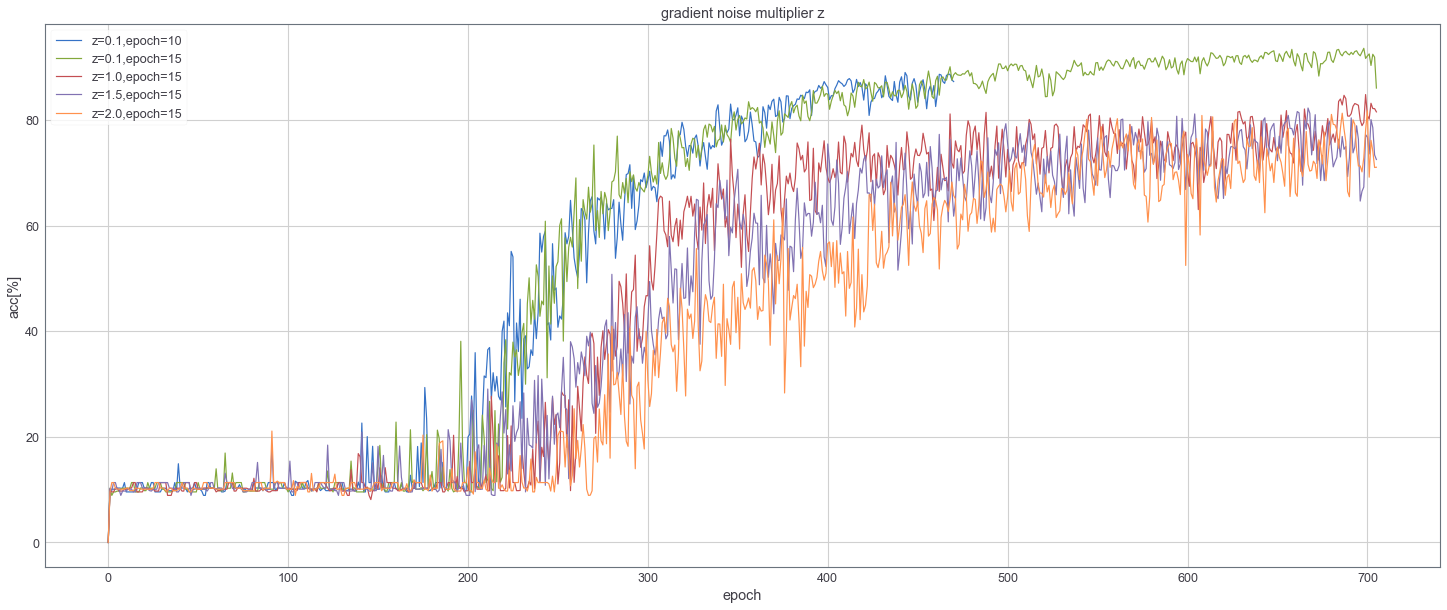

In [12]:
params_plot('./Eva/comb_params_setting/comb_noising_z.txt', 
            './Eva/comb_params_setting/images/noising_z.png',
            'gradient noise multiplier z'
           )